In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import numpy as np

from Leviathan.other_games import (
    Game, SBAgent, GameWHistory, GameWHistoryS1Tn, HDAgent,
    suicide_bomber_pay_off, RPS_pay_off, Hawk_Dove_pay_off
)
import matplotlib.pyplot as plt
from typing import List

from utils import save

import networkx as nx 
import nxviz as nv

from tqdm.notebook import tqdm

## Analyze

In [14]:
def average_strategy(
    member_list: List[HDAgent]
):
    strategy_count_dict = dict([(key, np.zeros_like(stra)) for key, stra in member_list[0].strategy.items()])
    for mem in member_list:
        for key in mem.strategy.keys():
            if member_list[0].mixed_strategy:
                strategy_count_dict[key] += mem.strategy[key]
            else:
                strategy_count_dict[key][mem.decision(key)] += 1

    return dict([(key, stra / len(member_list)) for key, stra in strategy_count_dict.items()])

## Game

In [40]:
resource = 2
conflict = 4
off_set = -1

In [41]:
Hawk_Dove = Hawk_Dove_pay_off(resource, conflict, off_set)

game = GameWHistoryS1Tn(
    init_member_num=50,
    pay_off_matrix=Hawk_Dove,
    decision_history_len=3,
    history_len=3,
    mixed_strategy=True,
    apply_majority_voting=True,
    random_seed=1,
)

In [42]:
# # transfer strategy
# import copy
# path = "./data/May/05_15-55/"
# game_old = save.dill_load(path + "HD game.dill")
# for idx, mem in enumerate(game.current_members):
#     mem.strategy = copy.deepcopy(game_old.current_members[idx].strategy)

#### Run

In [43]:
round_num = 200
game_in_round = 10000

discard_rate = 0.2
mutation_rate = 0.02
strategy_drift_rate = 0.2
strategy_drift_strength = 0.05

In [44]:
ave_str_list = [average_strategy(game.current_members)]

In [45]:
for r in tqdm(range(round_num)):
    # game.forget()

    # game.discard_randomly(discard_rate)
    game.discard_member_by_payoff(discard_rate)
    game.bear_randomly(
        strategy_drift_rate,
        strategy_drift_strength,  
    )
    # game.bear_new_member_by_payoff(
    #     strategy_drift_rate,
    #     strategy_drift_strength,    
    # )
    game.mutation(mutation_rate)

    game.reset_fitness()
    game.multiple_game(game_in_round)

    ave_str_list.append(average_strategy(game.current_members))


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
path = save.datetime_dir("./data")

save.dill_dump(game, path + "HD game.dill")

Current save directory: ./data/May/16_14-18/


## Plot

In [49]:
# path = "./data/May/06_20-51/"
# game = save.dill_load(path + "HD game.dill")

In [50]:
last_ave_str = ave_str_list[-1]
# sort the keys based on the values
sorted_keys = sorted(last_ave_str, key=lambda k: last_ave_str.get(k)[0], reverse=True)


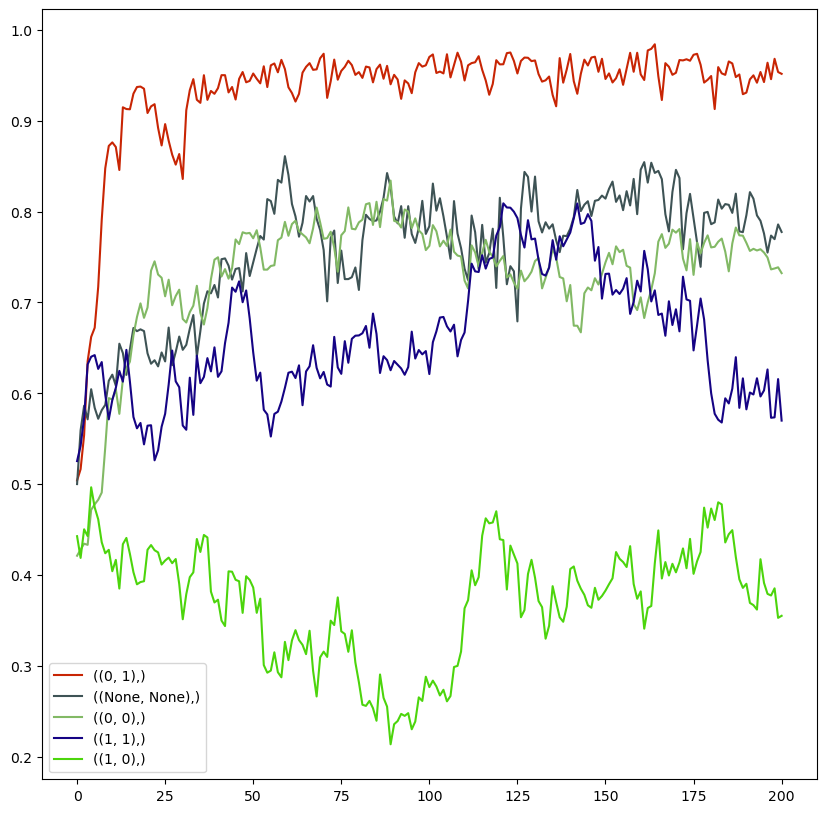

In [51]:
# plot Hawk probability for different history_key in the same plot

last_ave_str = ave_str_list[-1]

plt.figure(figsize=(10, 10))
for key in sorted_keys:
    plt.plot([stra[key][0] for stra in ave_str_list], label=key, color=np.random.rand(3, ))
plt.legend()
plt.show()


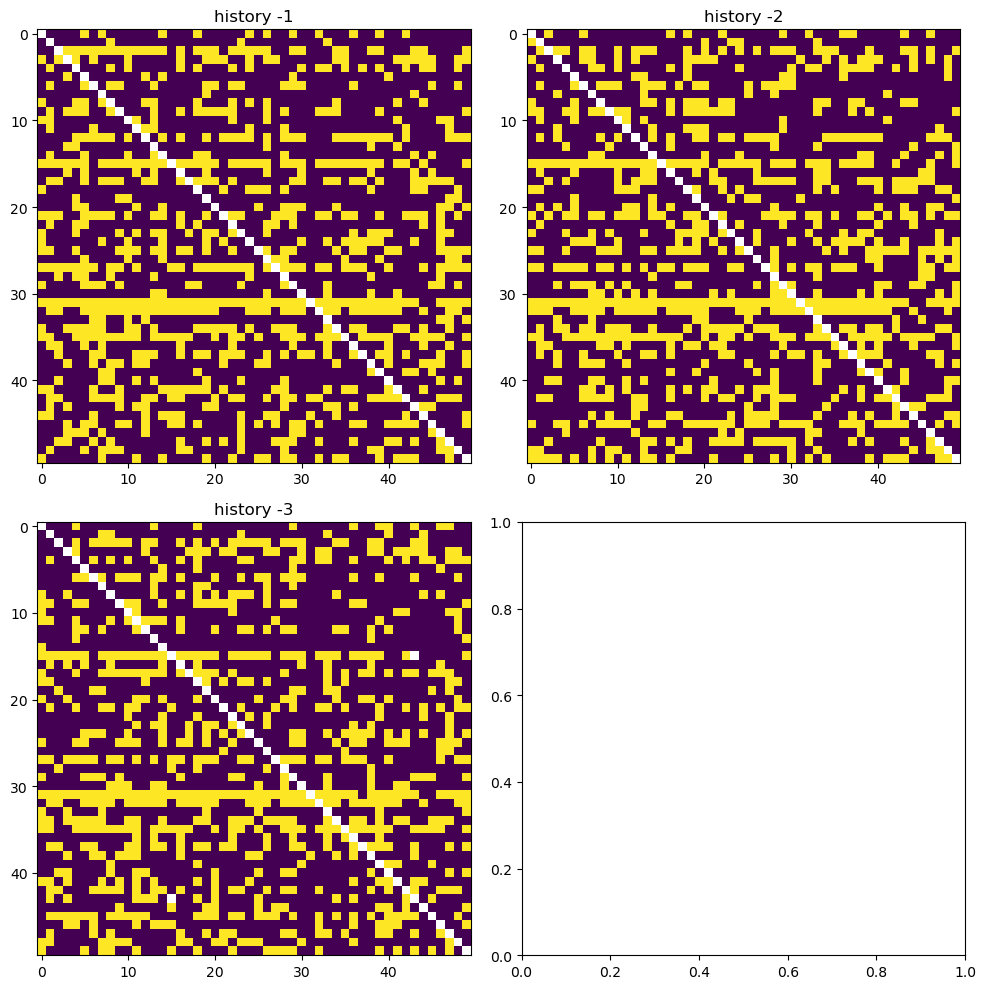

In [52]:
# plot the relationship matrices
row = 2
col = 2
fig, axs = plt.subplots(row, col, figsize=(10, 10))
for idx, (key, rela) in enumerate(game.relationship_dict.items()):
    ax = axs[idx // row, idx % col]
    im = ax.imshow(rela)
    ax.set_title(key)
    
# colorbar for the rightmost plot
# fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## strategy in a ND space

In [53]:
# strategy_ND has shape (member_num, strategy_num)
strategy_ND = []
for mem in game.current_members:
    strategy_mem = [value[0] for value in mem.strategy.values()]
    strategy_ND.append(strategy_mem)

strategy_ND = np.array(strategy_ND)
    

#### Hist plot for a single strategy

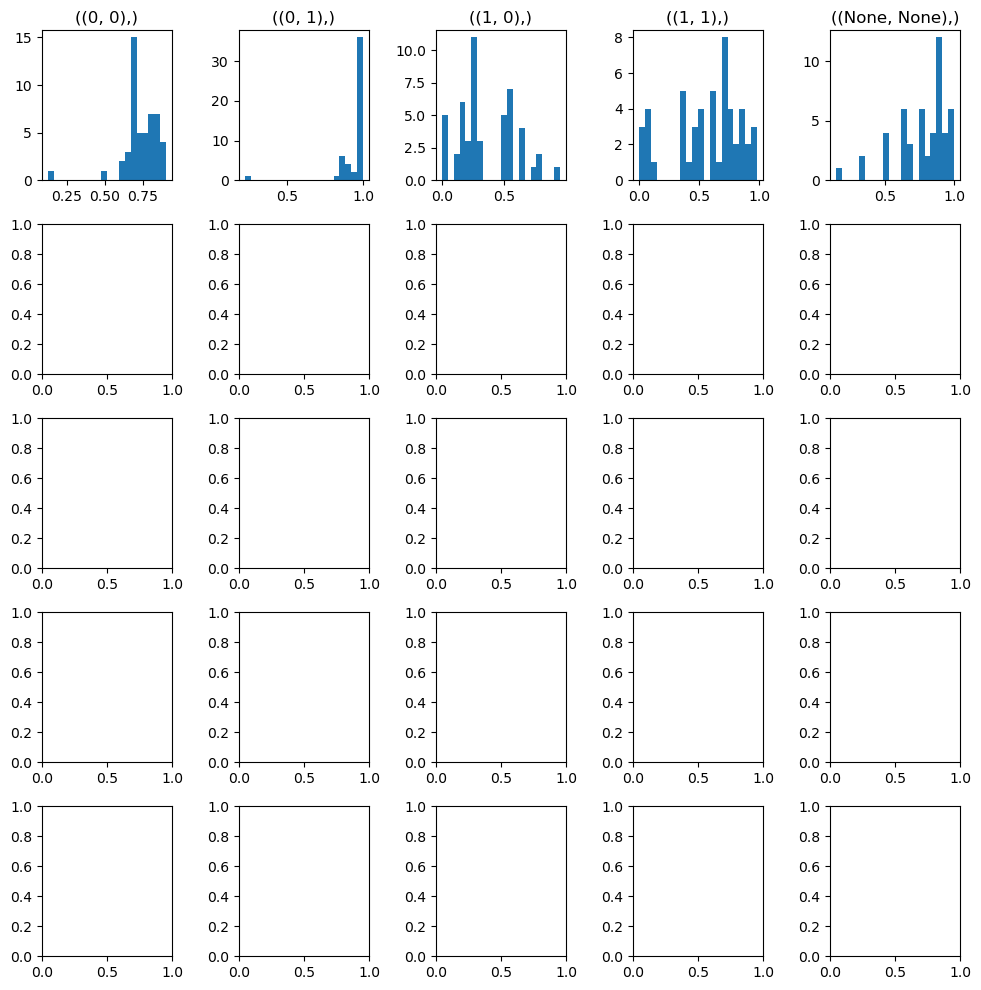

In [54]:
# hist plot for strategy_ND on each strategy
row = 5
col = 5
fig, axs = plt.subplots(row, col, figsize=(10, 10))
axs = axs.flatten()
for idx, key in enumerate(game.current_members[0].history_keys):
    ax = axs[idx]
    ax.hist(strategy_ND[:, idx], bins=20)
    ax.set_title(key)

plt.tight_layout()
plt.show()

#### Scatter plot to see the correlation between strategies

In [ ]:
# for different his_key_1 and his_key_2 from 0 to 4, plot the scatter plot

row = 25
col = 25
fig, axs = plt.subplots(row, col, figsize=(40, 40))

idx = 0
for his_key_1, his_key_2 in np.ndindex((row, col)):
    ax = axs[his_key_1, his_key_2]

    if his_key_2 != his_key_1:
        ax.scatter(strategy_ND[:, his_key_2], strategy_ND[:, his_key_1], alpha=0.1, s=2)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, 1)
        idx += 1

    # disable the axis except for the leftmost and bottommost
    if his_key_1 != row - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel(game.current_members[0].history_keys[his_key_2])

    if his_key_2 != 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel(game.current_members[0].history_keys[his_key_1])



plt.tight_layout()
plt.show()


#### What about network structure?

In [28]:
his_1 = game.relationship_dict["history -1"]

G_his_1_hawk = nx.DiGraph()
G_his_1_hawk.add_nodes_from(range(len(his_1)))
G_his_1_hawk.add_edges_from(np.argwhere(his_1 == 0))
G_his_1_hawk.name = "Hawk"

G_his_1_dove = nx.DiGraph()
G_his_1_dove.add_nodes_from(range(len(his_1)))
G_his_1_dove.add_edges_from(np.argwhere(his_1 == 1))
G_his_1_dove.name = "Dove"


In [29]:
his_1_mutual = his_1.copy()
his_1_mutual[his_1 != his_1.T] = np.nan
np.fill_diagonal(his_1_mutual, np.nan)

G_his_1_mut_friend = nx.Graph()
G_his_1_mut_friend.add_nodes_from(range(len(his_1)))
G_his_1_mut_friend.add_edges_from(np.argwhere(his_1_mutual == 1))
G_his_1_mut_friend.name = "Friend"

G_his_1_mut_enemy = nx.Graph()
G_his_1_mut_enemy.add_nodes_from(range(len(his_1)))
G_his_1_mut_enemy.add_edges_from(np.argwhere(his_1_mutual == 0))
G_his_1_mut_enemy.name = "Enemy"

G_his_1_mut_non_enemy = nx.Graph()
G_his_1_mut_non_enemy.add_nodes_from(range(len(his_1)))
G_his_1_mut_non_enemy.add_edges_from(np.argwhere(his_1_mutual != 0))
G_his_1_mut_non_enemy.name = "Non Enemy"

In [30]:
his_2 = game.relationship_dict["history -2"]

his_2_mutual = his_2.copy()
his_2_mutual[his_2 != his_2.T] = np.nan
np.fill_diagonal(his_2_mutual, np.nan)

G_his_12_mut_friend = nx.Graph()
G_his_12_mut_friend.add_nodes_from(range(len(his_2)))
G_his_12_mut_friend.add_edges_from(np.argwhere(np.logical_and(his_1_mutual == 1, his_2_mutual == 1)))
G_his_12_mut_friend.name = "Friend 12"

G_his_12_mut_enemy = nx.Graph()
G_his_12_mut_enemy.add_nodes_from(range(len(his_2)))
G_his_12_mut_enemy.add_edges_from(np.argwhere(np.logical_and(his_1_mutual == 0, his_2_mutual == 0)))
G_his_12_mut_enemy.name = "Enemy 12"

G_his_12_mut_non_enemy = nx.Graph()
G_his_12_mut_non_enemy.add_nodes_from(range(len(his_2)))
G_his_12_mut_non_enemy.add_edges_from(np.argwhere(np.logical_and(his_1_mutual != 0, his_2_mutual != 0)))
G_his_12_mut_non_enemy.name = "Non Enemy 12"

In [31]:
his_3 = game.relationship_dict["history -3"]

his_3_mutual = his_3.copy()
his_3_mutual[his_3 != his_3.T] = np.nan
np.fill_diagonal(his_3_mutual, np.nan)

G_his_123_mut_friend = nx.Graph()
G_his_123_mut_friend.add_nodes_from(range(len(his_3)))
G_his_123_mut_friend.add_edges_from(np.argwhere(np.logical_and(np.logical_and(his_1_mutual == 1, his_2_mutual == 1), his_3_mutual == 1)))
G_his_123_mut_friend.name = "Friend 123"

G_his_123_mut_enemy = nx.Graph()
G_his_123_mut_enemy.add_nodes_from(range(len(his_3)))
G_his_123_mut_enemy.add_edges_from(np.argwhere(np.logical_and(np.logical_and(his_1_mutual == 0, his_2_mutual == 0), his_3_mutual == 0)))
G_his_123_mut_enemy.name = "Enemy 123"

G_his_123_mut_non_enemy = nx.Graph()
G_his_123_mut_non_enemy.add_nodes_from(range(len(his_3)))
G_his_123_mut_non_enemy.add_edges_from(np.argwhere(np.logical_and(np.logical_and(his_1_mutual != 0, his_2_mutual != 0), his_3_mutual != 0)))
G_his_123_mut_non_enemy.name = "Non Enemy 123"


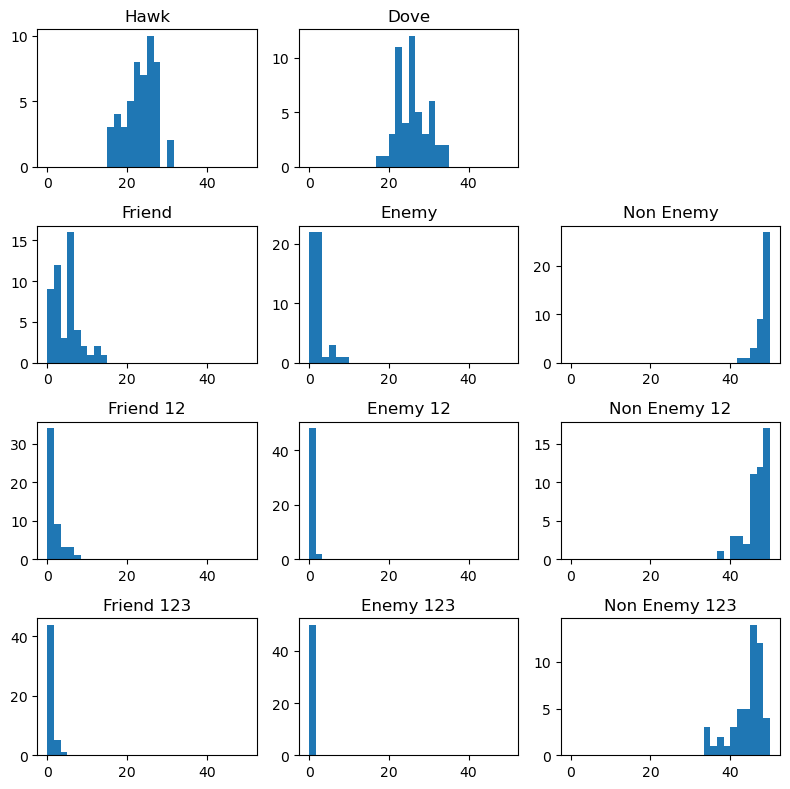

In [32]:
# plot degree distribution for G_his_1_hawk, G_his_1_dove, G_his_1_mut_friend, G_his_1_mut_enemy
fig, axs = plt.subplots(4, 3, figsize=(8, 8))
axs = axs.flatten()
for idx, G in enumerate([
    G_his_1_hawk, G_his_1_dove, None,
    G_his_1_mut_friend, G_his_1_mut_enemy, G_his_1_mut_non_enemy,
    G_his_12_mut_friend, G_his_12_mut_enemy, G_his_12_mut_non_enemy,
    G_his_123_mut_friend, G_his_123_mut_enemy, G_his_123_mut_non_enemy,
]):
    ax = axs[idx]
    if G is None:
        ax.axis("off")
        continue
    try:
        degree = [d for n, d in G.out_degree()]
    except AttributeError:
        degree = [d for n, d in G.degree()]

    # set range of hist to be (0, G.number_of_nodes)
    ax.hist(degree, bins=30, range=(0, G.number_of_nodes()))
    ax.set_title(G.name)

plt.tight_layout()
plt.show()

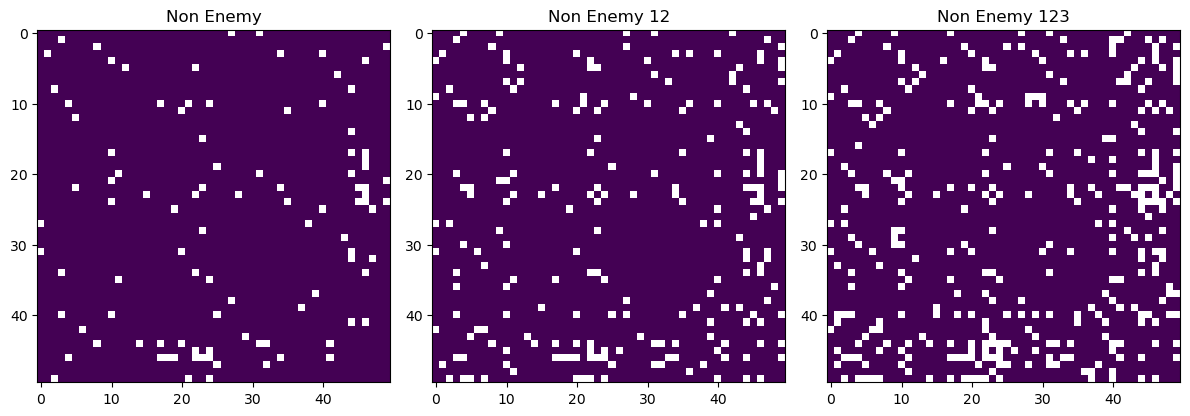

In [33]:
# get a adjacency matrix from a networkx
def get_adj_matrix(G):
    adj_matrix = np.full((len(G), len(G)), np.nan)
    for edge in G.edges:
        adj_matrix[edge[0], edge[1]] = 1
        adj_matrix[edge[1], edge[0]] = 1
    return adj_matrix

# plot the adjacency matrix for G_his_1_non_enemy, G_his_12_non_enemy, G_his_123_non_enemy
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.imshow(get_adj_matrix(G_his_1_mut_non_enemy))
ax.set_title(G_his_1_mut_non_enemy.name)

ax = axs[1]
ax.imshow(get_adj_matrix(G_his_12_mut_non_enemy))
ax.set_title(G_his_12_mut_non_enemy.name)

ax = axs[2]
ax.imshow(get_adj_matrix(G_his_123_mut_non_enemy))
ax.set_title(G_his_123_mut_non_enemy.name)

plt.tight_layout()
plt.show()


In [34]:
G = G_his_123_mut_non_enemy
adj_matrix = get_adj_matrix(G)
res = nx.community.asyn_fluidc(G, 15, max_iter=1000)
new_order = np.concatenate([list(r) for r in res])


In [35]:
ordered_adj_matrix = adj_matrix[np.ix_(new_order, new_order)]

2166.0


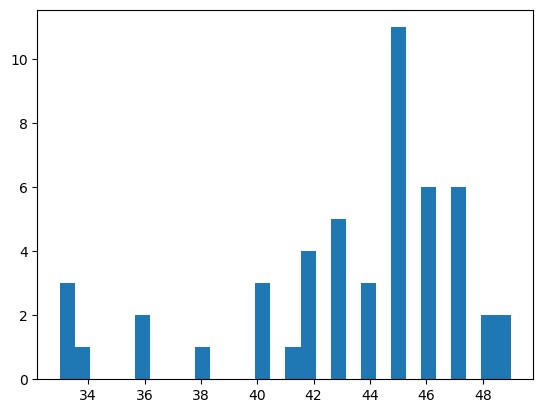

In [36]:
test = adj_matrix.copy()
test[np.isnan(test)] = 0
print(np.sum(test))
plt.hist(np.sum(test, axis=0), bins=30)
plt.show()


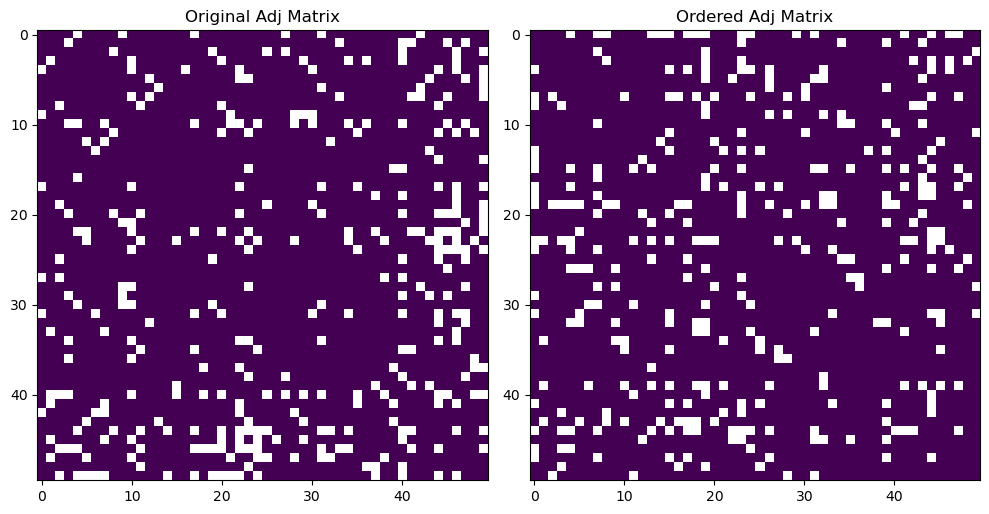

In [37]:
# plot the original adj_matrix and ordered_adj_matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
im = ax.imshow(adj_matrix)
ax.set_title("Original Adj Matrix")

ax = axs[1]
im = ax.imshow(ordered_adj_matrix)
ax.set_title("Ordered Adj Matrix")

plt.tight_layout()
plt.show()